# 02c Merge datasets across regions and domains 

---

In [11]:
#|default_exp core.02c_merge_data

In [12]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [13]:
#|hide
from nbdev.showdoc import show_doc

In [14]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [15]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

--- 

In [26]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

# and the GP practice catchment overlap with LADs
df_LAD_GP_pop = pd.read_csv(const.output_path+'/GP_LAD_intersections.csv')

In [17]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [18]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [19]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

Also want to look at the health conditions which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)

Could also consider:
- Depression (DEP)
- Parkinsonism - not in the QOF dataset - I suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [20]:
# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

# drop some duplicated columns 
df_dem_covar.drop(axis=1, labels=['Area name_x', 'Area name_y', 'LAD_name'], inplace=True)

In [21]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8


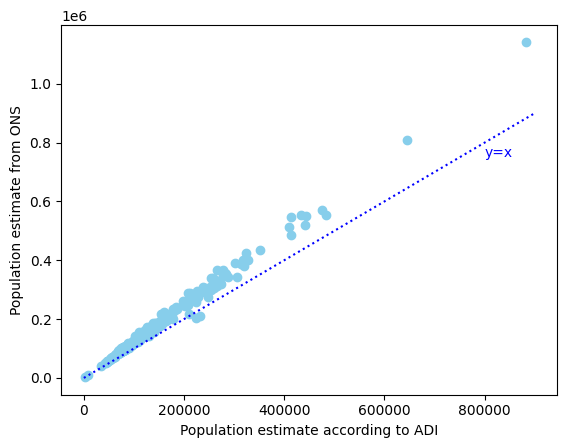

In [22]:
plt.scatter(df_dem_covar['pop'], df_dem_covar['all_age'], color = 'skyblue')
plt.plot(np.arange(900000), np.arange(900000), ':', color='b')
plt.text(800000, 750000, r'y=x', fontsize=10, color='b')
plt.xlabel('Population estimate according to ADI')
plt.ylabel('Population estimate from ONS')
plt.show()

In [23]:
# and columns with disease prevalence for the comorbidities of hypertension (HYP), diabetes (DM) and stroke (STIA)
df_dem_covar['HYP_afflicted_pc'] = df_dem_covar['HYP_afflicted']/df_dem_covar['pop']
df_dem_covar['DM_afflicted_pc'] = df_dem_covar['DM_afflicted']/df_dem_covar['pop']
df_dem_covar['STIA_afflicted_pc'] = df_dem_covar['STIA_afflicted']/df_dem_covar['pop']

In [25]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2,0.190731,0.061649,0.029487
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0,0.103726,0.036506,0.012880
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2,0.135847,0.048480,0.019880
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8,0.136400,0.055064,0.021488
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8,0.159655,0.062981,0.022507


In [24]:
# save a .csv of `df_dem_covar`
df_dem_covar.to_csv(const.output_path+'/df_dem_plus.csv', index=False)

In [27]:
df_LAD_GP_pop

,gp_index,intersection_size,pop,LAD,gp_name
0,7228,154.810845,51241.009004,Hartlepool,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE
1,1607,168.866010,55893.143290,Hartlepool,A81622 - GLADSTONE HOUSE SURGERY
2,7219,185.284987,61327.677980,Hartlepool,A81060 - THE KOH PRACTICE
3,7959,189.603022,62756.909149,Hartlepool,A81044 - MCKENZIE HOUSE SURGERY
4,2654,214.436151,70976.453448,Hartlepool,A81007 - BANKHOUSE SURGERY
...,...,...,...,...,...
15167,8556,12.274104,45040.765372,Westminster,E87026 - MEANWHILE GARDEN MEDICAL CENTRE
15168,6172,0.000029,0.106191,Westminster,E87701 - THE ABINGDON HEALTH CENTRE
15169,4057,0.084800,311.181309,Westminster,F83048 - BRUNSWICK MEDICAL CENTRE UHPC
15170,4067,0.008687,31.875834,Westminster,F83058 - HOLBORN MEDICAL CENTRE


In [31]:
df_GP_count = pd.read_csv(const.data_path+'/GP_practices_dec_23/gp_Count.csv')

In [32]:
df_GP_count.head()

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,BARTS HEALTH NHS TRUST,R1H00,BARTS HEALTH NHS TRUST CHS,"BEAUMONT HOUSE, ROOM 31, MILE END HOSPITAL, LO...",Y05462,1,NaN,NaN,NaN
1,BEXLEY HEALTH NEIGHBOURHOOD CARE,DFJ00,GUARD YOUR HEART HUB,"C/O BELLGROVE SURGERY, 174 BELLGROVE ROAD, WEL...",Y08001,1,NaN,NaN,NaN
2,BMI HEALTHCARE,NT400,BMI BEAUMONT HOSPITAL,"OLD HALL CLOUGH, CHORLEY NEW ROAD LOSTOCK, BOL...",Y06646,1,NaN,NaN,NaN
3,BMI HEALTHCARE,NT400,BMI BISHOPSWOOD HOSPITAL,"RICKMANSWORTH ROAD, NORTHWOOD, MIDDLESEX, HA6 2JW",Y06603,1,NaN,NaN,NaN
4,BMI HEALTHCARE,NT400,BMI CHAUCER HOSPITAL,"NACKINGTON ROAD, CANTERBURY, KENT, CT4 7AR",Y04413,1,NaN,NaN,NaN


In [37]:
df_LAD_GP_pop[df_LAD_GP_pop['gp_name'].str.contains("A81044")]

,gp_index,intersection_size,pop,LAD,gp_name
3,7959,189.603022,62756.909149,Hartlepool,A81044 - MCKENZIE HOUSE SURGERY


In [41]:
# Need to finish this tomorrow! 

df_LAD_GP_pop['GP_count'] = []
for gp_codename in df_GP_count['Code.1'].values: 
    codename_match = df_LAD_GP_pop[df_LAD_GP_pop['gp_name'].str.contains(gp_codename)]
    gp_index = codename_match['gp_index']
    if len(codename_match) == 1:
        df_LAD_GP_pop[df_LAD_GP_pop['gp_index']==gp_index]['GP_count'] = df_GP_count

array(['Y05462', 'Y08001', 'Y06646', ..., 'Y06365', 'Y06366', 'Y06367'],
      dtype=object)